In [3]:
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

class PandasData(bt.feed.DataBase):
    '''
    The ``dataname`` parameter inherited from ``bt.feed.DataBase`` is the pandas
    DataFrame
    '''

    params = (
        # Possible values for datetime (must always be present)
        #  None : datetime is the "index" in the Pandas Dataframe
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('datetime', None),

        # Possible values below:
        #  None : column not present
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', None),
    )

# Data Feed
# usually consists of Open, High, Low, Close, Volume, OpenInterest
files_dict = {
    'FTM': {'csv':r'C:\Users\justi\crypto-vol-scanner\downloaded_data\BINANCE_FTMUSD, 1D.csv', 'name':'FTM'},
    'SOL': {'csv':r'C:\Users\justi\crypto-vol-scanner\downloaded_data\BINANCE_SOLUSD, 1D.csv', 'name':'SOL'},
    'THETA': {'csv':r'C:\Users\justi\crypto-vol-scanner\downloaded_data\BINANCE_THETAUSD, 1D.csv', 'name':'THETA'},
    'AXS': {'csv':r'C:\Users\justi\crypto-vol-scanner\downloaded_data\FTX_AXSUSD, 1D.csv', 'name':'AXS'},
    'HNT': {'csv':r'C:\Users\justi\crypto-vol-scanner\downloaded_data\FTX_HNTUSD, 1D (1).csv', 'name':'HNT'},
    'MATIC': {'csv':r'C:\Users\justi\crypto-vol-scanner\downloaded_data\FTX_MATICUSD, 1D.csv', 'name':'MATIC'},
}

# datapath = os.path.join(r'C:\Users\justi\crypto-vol-scanner\downloaded_data\FTX_HNTUSD, 1D (1).csv')
df_list =[]
data_list = []
for file in files_dict.keys():
    datapath = files_dict[file]['csv']
    df_list.append(pd.read_csv(datapath, index_col=0, parse_dates=True))
    data_list.append((bt.feeds.PandasData(dataname=df_list[-1],),files_dict[file]['name']))




Link used for example:
https://www.backtrader.com/docu/quickstart/quickstart/

In [10]:
class VolumeStrategy(bt.Strategy):
    params = (
        ('MaxTriggerNumber', int(1)),
        ('VolAvgLength', int(50)),
        ('TriggerPriceMultiplier', 10.0),
        ('TriggerVolumeMultiplier', 10.0),
    )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        '''
        Create an dictionary of indicators so that we can dynamically add the
        indicators to the strategy using a loop. This mean the strategy will
        work with any number of data feeds. 
        '''
        self.inds = dict()
        for i, d in enumerate(self.datas):
            # indicator dictionary
            self.inds[d] = dict()
            
            # Add the indicators to the dictionary
            self.inds[d]['vol_avg'] = bt.indicators.Average(d.volume, period=self.params.VolAvgLength, 
                plot=True)

            # Add trigger variables
            self.inds[d]['initial_trigger'] = False
            self.inds[d]['trigger_number'] = 0
            self.inds[d]['vol_1d_lag'] = 0
            self.inds[d]['trigger_price'] = d.close * self.params.TriggerPriceMultiplier
            self.inds[d]['initial_price'] = 0
            self.inds[d]['target_price'] = 0

            # To keep track of pending orders and buy price/commission
            self.order = None
            self.buyprice = None
            self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))


    def next(self):
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name
            pos = self.getposition(d).size
            if not pos: # no position/no orders
                # Simply log the closing price of the series from the reference
                # self.log('Close, %.2f' % self.dataclose[0])

                # Not yet ... we MIGHT BUY if ...
                if d.volume > self.inds[d]['vol_1d_lag'] * self.params.TriggerVolumeMultiplier and self.inds[d]['initial_trigger'] == False:
                    self.inds[d]['initial_trigger'] = True
                    # worst possible price
                    self.inds[d]['initial_price'] = d.high[0]
                    self.inds[d]['target_price']  = self.inds[d]['initial_price']  * self.params.TriggerPriceMultiplier
                    # BUY, BUY, BUY!!!
                    self.log('BUY CREATE, %.2f' % d.high[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy(price=d.high[0], exectype=bt.Order.Limit, data=d)

            else:
                # add a sell order once the buy order is filled
                if self.inds[d]['initial_trigger'] == True and self.inds[d]['trigger_number'] < self.params.MaxTriggerNumber:
                    # Get limit order created to sell too
                    self.log('SELL CREATE, %.2f' % self.inds[d]['target_price'] )
                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.sell(price=self.inds[d]['target_price'] , exectype=bt.Order.Limit, data=d)
                    self.inds[d]['trigger_number'] = 1 + self.inds[d]['trigger_number']
                    
                    """
                    # SELL, SELL, SELL!!!
                    # worst possible price
                    self.log('SELL CREATE, %.2f' % self.inds[d]['target_price'] )

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.sell(price=self.inds[d]['target_price'] )"""
            
            self.inds[d]['vol_1d_lag'] = self.inds[d]['vol_avg'][0]
        



In [13]:
if __name__ == '__main__':
    cerebro = bt.Cerebro()

    for data in data_list:
        # Add the Data Feed to Cerebro
        cerebro.adddata(data[0], name=data[1])

    cerebro.addstrategy(VolumeStrategy)
    # cerebro.broker.setcommission(commission=0.005) # 0.5% commission
        
    SIZER_PERCENTAGE = 0.8
    STARTING_CASH = 10000.0/SIZER_PERCENTAGE
    cerebro.broker.setcash(STARTING_CASH) # optional, 10k starting cash default
    cerebro.addsizer(bt.sizers.PercentSizer, percents=SIZER_PERCENTAGE*100/10)
    
    print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')

    cerebro.run()
    final_cash = cerebro.broker.getvalue()-(STARTING_CASH-10000.0)
    print(f'Final Portfolio Value: {final_cash:.2f}')
    print(f'Multiplier on investment: {(final_cash-(STARTING_CASH*SIZER_PERCENTAGE))/(STARTING_CASH*SIZER_PERCENTAGE):.2f}x')

    


Starting Portfolio Value: 12500.00
2021-05-25, BUY CREATE, 0.37
2021-05-25, BUY CREATE, 33.56
2021-05-25, BUY CREATE, 7.37
2021-05-25, BUY CREATE, 4.35
2021-05-25, BUY CREATE, 14.96
2021-05-25, BUY CREATE, 1.95
2021-05-26, BUY EXECUTED, Price: 0.33, Cost: 999.80, Comm 0.00
2021-05-26, BUY EXECUTED, Price: 30.03, Cost: 1001.01, Comm 0.00
2021-05-26, BUY EXECUTED, Price: 6.90, Cost: 1001.25, Comm 0.00
2021-05-26, BUY EXECUTED, Price: 4.06, Cost: 1000.00, Comm 0.00
2021-05-26, BUY EXECUTED, Price: 13.93, Cost: 1000.00, Comm 0.00
2021-05-26, BUY EXECUTED, Price: 1.94, Cost: 1000.00, Comm 0.00
2021-05-26, SELL CREATE, 3.71
2021-05-26, SELL CREATE, 335.60
2021-05-26, SELL CREATE, 73.71
2021-05-26, SELL CREATE, 43.50
2021-05-26, SELL CREATE, 149.56
2021-05-26, SELL CREATE, 19.50
2021-07-23, SELL EXECUTED, Price: 43.50, Cost: 1000.00, Comm 0.00
2021-07-23, OPERATION PROFIT, GROSS 9703.74, NET 9703.74
Final Portfolio Value: 31459.06
Multiplier on investment: 2.15x


In [14]:
def saveplots(cerebro, numfigs=1, iplot=True, start=None, end=None,
             width=16, height=9, dpi=300, tight=True, use=None, file_path = '', **kwargs):

        from backtrader import plot
        if cerebro.p.oldsync:
            plotter = plot.Plot_OldSync(**kwargs)
        else:
            plotter = plot.Plot(**kwargs)

        figs = []
        for stratlist in cerebro.runstrats:
            for si, strat in enumerate(stratlist):
                rfig = plotter.plot(strat, figid=si * 100,
                                    numfigs=numfigs, iplot=iplot,
                                    start=start, end=end, use=use)
                figs.append(rfig)

        for fig in figs:
            for f in fig:
                f.savefig(file_path, bbox_inches='tight')
        return figs

saveplots(cerebro, file_path = 'results/savefig.png') #run it

<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 20 Axes>]]

<IPython.core.display.Javascript object>

AttributeError: 'list' object has no attribute 'savefig'

<AxesSubplot:>

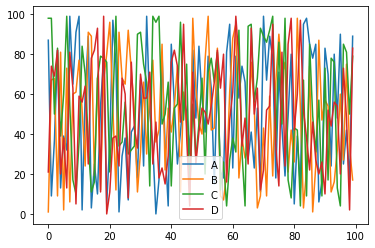

In [1]:
import numpy as np
import pandas as pd

df = pd.DataFrame(np.random.randint(0,100,size=(100,4)),columns = list('ABCD'))
df.head()
df.plot()

In [ ]:
print()